# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

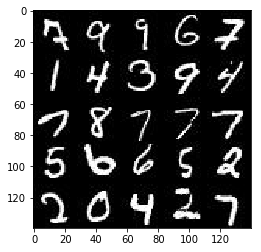

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

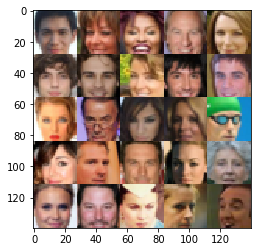

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input_images = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input')
    z_data = tf.placeholder(tf.float32, [None, z_dim], name='z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return real_input_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Helper Method
Each convolution goes throught the same process of batch_normalization and then a leaky relu

In [6]:
def batch_lrelu(x, alpha=0.1, batch_normalization=True, is_train=True):
    if batch_normalization:
        temp = tf.layers.batch_normalization(x, training=is_train)
        return tf.maximum(alpha * x, x)
    else:
        return tf.maximum(alpha * x, x) 

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    kernal_size = 5
    filters = [64, 128, 256, 512]
    with tf.variable_scope('discriminator', reuse=reuse):
        c1 = tf.layers.conv2d(images, filters[0], kernal_size, strides=2, padding='same')
        c1 = batch_lrelu(c1, batch_normalization=False)

        c1 = tf.layers.conv2d(c1, filters[1], kernal_size, strides=2, padding='same')
        c1 = batch_lrelu(c1)

        c1 = tf.layers.conv2d(c1, filters[2], kernal_size, strides=2, padding='same')
        c1 = batch_lrelu(c1)
        
        flat = tf.reshape(c1, [-1, 4 * 4 * filters[2]])
        logits = tf.layers.dense(flat, 1)
        output = tf.tanh(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    kernal_size = 5
    filters = [512, 256, 128, 64]
    with tf.variable_scope('generator', reuse=not is_train):
        h1 = tf.layers.dense(z, 7 * 7 * filters[0])

        c1 = tf.reshape(h1, [-1, 7, 7, filters[0]])
        c1 = tf.layers.conv2d_transpose(c1, filters[1], 5, strides=2, padding='same')
        c1 = batch_lrelu(c1)

        c1 = tf.layers.conv2d_transpose(c1, filters[2], 5, strides=2, padding='same')
        c1 = batch_lrelu(c1)

        logit = tf.layers.conv2d_transpose(c1, out_channel_dim, 5, strides=1, padding='same')
        output = tf.tanh(logit)

    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                      labels=tf.ones_like(d_model_real) * (1 - smooth))) 
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                      labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_model_fake)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    t_vars = tf.trainable_variables()
    g_var = [var for var in t_vars if var.name.startswith('generator')]
    d_var = [var for var in t_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list = g_var)
        d_train = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list = d_var)
    return d_train, g_train


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, image_width, image_height, image_channels = data_shape
    input_data, z_data, t_lr = model_inputs(image_width, image_height, image_channels, z_dim)   
    disc_loss, gen_loss = model_loss(input_data, z_data, image_channels)
    disc_train, gen_train = model_opt(disc_loss, gen_loss, t_lr, beta1)

    steps = 0
    losses = {'g_loss': [], 'd_loss': []}

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2
                noise_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(disc_train, feed_dict={input_data: batch_images, z_data: noise_z, t_lr: learning_rate})
                _ = sess.run(gen_train, feed_dict={input_data: batch_images, z_data: noise_z, t_lr: learning_rate})
                
                if not steps % 10:
                    training_loss_d = sess.run(disc_loss, feed_dict={input_data: batch_images, z_data: noise_z})
                    training_loss_g = sess.run(gen_loss, feed_dict={z_data: noise_z})
                    losses['g_loss'].append(training_loss_g)
                    losses['d_loss'].append(training_loss_d)
                    
                    print('Epoch: {} Gen Loss: {:.4f} Disc Loss: {:.4f}'.format(epoch_i, training_loss_g, training_loss_d))
                
                if not steps % 100:
                    show_generator_output(sess, 5 * 5, z_data, image_channels, image_mode=data_image_mode)
    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch: 0 Gen Loss: 0.5485 Disc Loss: 1.1973
Epoch: 0 Gen Loss: 0.7069 Disc Loss: 1.0618
Epoch: 0 Gen Loss: 1.0438 Disc Loss: 0.8045
Epoch: 0 Gen Loss: 0.7974 Disc Loss: 0.9805
Epoch: 0 Gen Loss: 0.8612 Disc Loss: 0.8842
Epoch: 0 Gen Loss: 0.9075 Disc Loss: 0.8639
Epoch: 0 Gen Loss: 0.9307 Disc Loss: 0.8487
Epoch: 0 Gen Loss: 1.2361 Disc Loss: 0.6762
Epoch: 0 Gen Loss: 1.8774 Disc Loss: 0.5001
Epoch: 0 Gen Loss: 2.7364 Disc Loss: 0.4022


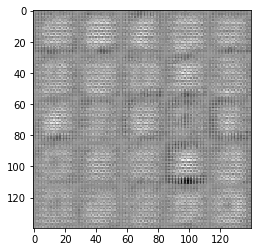

Epoch: 0 Gen Loss: 3.3009 Disc Loss: 0.3837
Epoch: 0 Gen Loss: 2.5105 Disc Loss: 0.6118
Epoch: 0 Gen Loss: 2.7982 Disc Loss: 0.8898
Epoch: 0 Gen Loss: 1.7179 Disc Loss: 0.6652
Epoch: 0 Gen Loss: 1.5703 Disc Loss: 0.9233
Epoch: 0 Gen Loss: 1.7003 Disc Loss: 1.1097
Epoch: 0 Gen Loss: 1.1563 Disc Loss: 1.0952
Epoch: 0 Gen Loss: 1.6286 Disc Loss: 1.0997
Epoch: 0 Gen Loss: 1.6813 Disc Loss: 0.6992
Epoch: 0 Gen Loss: 1.7732 Disc Loss: 0.8466


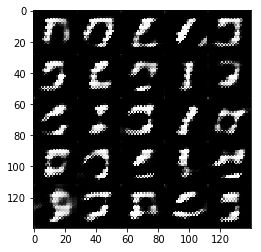

Epoch: 0 Gen Loss: 0.9533 Disc Loss: 1.1062
Epoch: 0 Gen Loss: 0.8333 Disc Loss: 1.3047
Epoch: 0 Gen Loss: 1.1914 Disc Loss: 1.4603
Epoch: 0 Gen Loss: 0.9256 Disc Loss: 1.3958
Epoch: 0 Gen Loss: 0.8861 Disc Loss: 1.2464
Epoch: 0 Gen Loss: 1.1556 Disc Loss: 1.3093
Epoch: 0 Gen Loss: 0.8652 Disc Loss: 1.4836
Epoch: 0 Gen Loss: 1.2382 Disc Loss: 1.1101
Epoch: 0 Gen Loss: 1.6513 Disc Loss: 0.8321
Epoch: 0 Gen Loss: 1.2060 Disc Loss: 1.0368


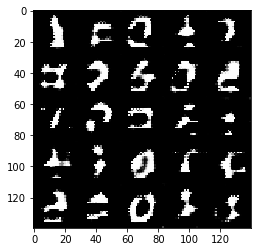

Epoch: 0 Gen Loss: 1.0996 Disc Loss: 1.1255
Epoch: 0 Gen Loss: 0.8825 Disc Loss: 1.4728
Epoch: 0 Gen Loss: 0.9721 Disc Loss: 1.5022
Epoch: 0 Gen Loss: 0.7372 Disc Loss: 1.5574
Epoch: 0 Gen Loss: 0.8598 Disc Loss: 1.3059
Epoch: 0 Gen Loss: 1.1006 Disc Loss: 1.0654
Epoch: 0 Gen Loss: 1.3098 Disc Loss: 0.9695
Epoch: 0 Gen Loss: 1.2572 Disc Loss: 0.9752
Epoch: 0 Gen Loss: 0.9772 Disc Loss: 1.2016
Epoch: 0 Gen Loss: 0.9076 Disc Loss: 1.3688


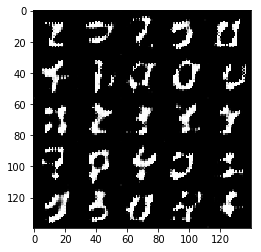

Epoch: 0 Gen Loss: 0.9051 Disc Loss: 1.4420
Epoch: 0 Gen Loss: 1.0971 Disc Loss: 1.1827
Epoch: 0 Gen Loss: 1.2512 Disc Loss: 0.9647
Epoch: 0 Gen Loss: 1.3361 Disc Loss: 0.9025
Epoch: 0 Gen Loss: 1.1902 Disc Loss: 1.0459
Epoch: 0 Gen Loss: 0.9250 Disc Loss: 1.2801
Epoch: 0 Gen Loss: 0.9818 Disc Loss: 1.2539
Epoch: 0 Gen Loss: 0.9702 Disc Loss: 1.2842
Epoch: 0 Gen Loss: 0.9990 Disc Loss: 1.3618
Epoch: 0 Gen Loss: 1.0547 Disc Loss: 1.1502


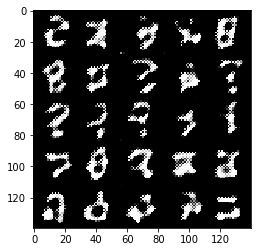

Epoch: 0 Gen Loss: 1.1879 Disc Loss: 0.9346
Epoch: 0 Gen Loss: 1.0995 Disc Loss: 0.9543
Epoch: 0 Gen Loss: 1.3062 Disc Loss: 1.0247
Epoch: 0 Gen Loss: 1.1240 Disc Loss: 1.1706
Epoch: 0 Gen Loss: 0.7727 Disc Loss: 1.4922
Epoch: 0 Gen Loss: 0.7276 Disc Loss: 1.5111
Epoch: 0 Gen Loss: 1.2828 Disc Loss: 0.9292
Epoch: 0 Gen Loss: 1.1327 Disc Loss: 1.0668
Epoch: 0 Gen Loss: 1.1348 Disc Loss: 1.2422
Epoch: 0 Gen Loss: 1.0807 Disc Loss: 1.2449


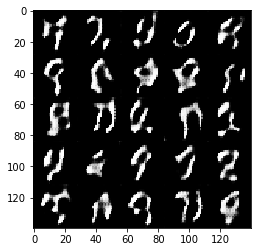

Epoch: 0 Gen Loss: 1.0453 Disc Loss: 1.4476
Epoch: 0 Gen Loss: 0.8718 Disc Loss: 1.4408
Epoch: 0 Gen Loss: 1.3286 Disc Loss: 1.0327
Epoch: 0 Gen Loss: 0.7725 Disc Loss: 1.9239
Epoch: 0 Gen Loss: 1.3740 Disc Loss: 0.8616
Epoch: 0 Gen Loss: 0.9375 Disc Loss: 1.4769
Epoch: 0 Gen Loss: 1.2955 Disc Loss: 1.0457
Epoch: 0 Gen Loss: 0.7094 Disc Loss: 1.6031
Epoch: 0 Gen Loss: 1.1023 Disc Loss: 1.1505
Epoch: 0 Gen Loss: 0.8738 Disc Loss: 1.7140


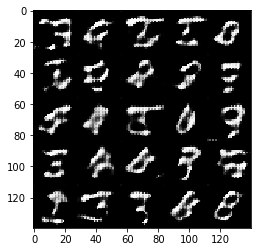

Epoch: 0 Gen Loss: 1.3098 Disc Loss: 0.9685
Epoch: 0 Gen Loss: 0.9469 Disc Loss: 1.2228
Epoch: 0 Gen Loss: 0.8788 Disc Loss: 1.3747
Epoch: 0 Gen Loss: 1.1791 Disc Loss: 1.1218
Epoch: 0 Gen Loss: 0.9718 Disc Loss: 1.2943
Epoch: 0 Gen Loss: 0.9462 Disc Loss: 1.2243
Epoch: 0 Gen Loss: 1.1828 Disc Loss: 1.0706
Epoch: 0 Gen Loss: 1.0674 Disc Loss: 1.1214
Epoch: 0 Gen Loss: 1.1086 Disc Loss: 1.0543
Epoch: 0 Gen Loss: 1.1489 Disc Loss: 1.2576


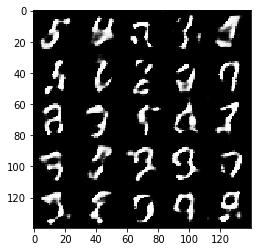

Epoch: 0 Gen Loss: 0.8058 Disc Loss: 1.4690
Epoch: 0 Gen Loss: 1.0465 Disc Loss: 1.2208
Epoch: 0 Gen Loss: 0.7551 Disc Loss: 1.3607
Epoch: 0 Gen Loss: 0.8813 Disc Loss: 1.3218
Epoch: 0 Gen Loss: 1.1755 Disc Loss: 1.1765
Epoch: 0 Gen Loss: 1.0090 Disc Loss: 1.2942
Epoch: 0 Gen Loss: 1.0109 Disc Loss: 1.2133
Epoch: 0 Gen Loss: 0.9172 Disc Loss: 1.1896
Epoch: 0 Gen Loss: 0.9269 Disc Loss: 1.3737
Epoch: 0 Gen Loss: 0.9278 Disc Loss: 1.2917


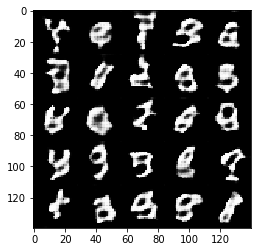

Epoch: 0 Gen Loss: 1.0436 Disc Loss: 1.2412
Epoch: 0 Gen Loss: 0.9721 Disc Loss: 1.2279
Epoch: 0 Gen Loss: 1.1307 Disc Loss: 1.0898
Epoch: 1 Gen Loss: 1.0077 Disc Loss: 1.2785
Epoch: 1 Gen Loss: 0.9524 Disc Loss: 1.2649
Epoch: 1 Gen Loss: 0.7246 Disc Loss: 1.3805
Epoch: 1 Gen Loss: 0.8390 Disc Loss: 1.2809
Epoch: 1 Gen Loss: 0.9624 Disc Loss: 1.1259
Epoch: 1 Gen Loss: 0.9568 Disc Loss: 1.2899
Epoch: 1 Gen Loss: 1.0735 Disc Loss: 1.0983


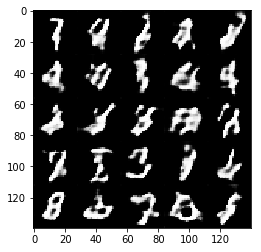

Epoch: 1 Gen Loss: 1.0635 Disc Loss: 1.1630
Epoch: 1 Gen Loss: 0.9246 Disc Loss: 1.3152
Epoch: 1 Gen Loss: 0.9382 Disc Loss: 1.3199
Epoch: 1 Gen Loss: 0.9338 Disc Loss: 1.3263
Epoch: 1 Gen Loss: 1.0599 Disc Loss: 1.1531
Epoch: 1 Gen Loss: 1.0632 Disc Loss: 1.0644
Epoch: 1 Gen Loss: 0.8979 Disc Loss: 1.4212
Epoch: 1 Gen Loss: 1.0367 Disc Loss: 1.1273
Epoch: 1 Gen Loss: 0.8888 Disc Loss: 1.4210
Epoch: 1 Gen Loss: 1.0783 Disc Loss: 1.1796


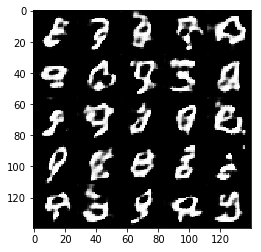

Epoch: 1 Gen Loss: 1.0838 Disc Loss: 1.0977
Epoch: 1 Gen Loss: 0.8765 Disc Loss: 1.3687
Epoch: 1 Gen Loss: 0.9293 Disc Loss: 1.2030
Epoch: 1 Gen Loss: 0.8759 Disc Loss: 1.3473
Epoch: 1 Gen Loss: 0.8556 Disc Loss: 1.3713
Epoch: 1 Gen Loss: 1.0984 Disc Loss: 1.0774
Epoch: 1 Gen Loss: 0.9212 Disc Loss: 1.2568
Epoch: 1 Gen Loss: 1.1178 Disc Loss: 1.2428
Epoch: 1 Gen Loss: 1.0456 Disc Loss: 1.1350
Epoch: 1 Gen Loss: 0.6803 Disc Loss: 1.5152


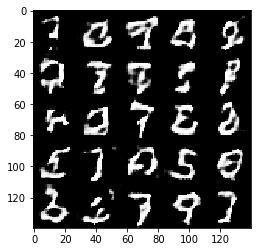

Epoch: 1 Gen Loss: 1.1267 Disc Loss: 1.1253
Epoch: 1 Gen Loss: 0.8634 Disc Loss: 1.2863
Epoch: 1 Gen Loss: 0.9306 Disc Loss: 1.2303
Epoch: 1 Gen Loss: 1.2236 Disc Loss: 1.1890
Epoch: 1 Gen Loss: 1.0118 Disc Loss: 1.2997
Epoch: 1 Gen Loss: 1.1067 Disc Loss: 1.2328
Epoch: 1 Gen Loss: 1.2101 Disc Loss: 1.2449
Epoch: 1 Gen Loss: 0.9658 Disc Loss: 1.2626
Epoch: 1 Gen Loss: 1.0987 Disc Loss: 1.1241
Epoch: 1 Gen Loss: 0.9697 Disc Loss: 1.2246


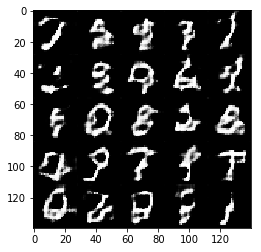

Epoch: 1 Gen Loss: 0.9735 Disc Loss: 1.2629
Epoch: 1 Gen Loss: 0.7455 Disc Loss: 1.6048
Epoch: 1 Gen Loss: 0.8388 Disc Loss: 1.4118
Epoch: 1 Gen Loss: 1.1708 Disc Loss: 1.0408
Epoch: 1 Gen Loss: 1.0543 Disc Loss: 1.0877
Epoch: 1 Gen Loss: 1.1444 Disc Loss: 1.1875
Epoch: 1 Gen Loss: 1.1161 Disc Loss: 1.2053
Epoch: 1 Gen Loss: 0.9176 Disc Loss: 1.3916
Epoch: 1 Gen Loss: 0.9873 Disc Loss: 1.2009
Epoch: 1 Gen Loss: 0.9610 Disc Loss: 1.3576


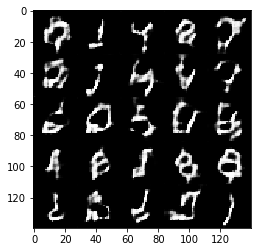

Epoch: 1 Gen Loss: 0.9956 Disc Loss: 1.3096
Epoch: 1 Gen Loss: 1.0865 Disc Loss: 1.0572
Epoch: 1 Gen Loss: 1.1219 Disc Loss: 1.2239
Epoch: 1 Gen Loss: 1.2388 Disc Loss: 1.1926
Epoch: 1 Gen Loss: 1.0006 Disc Loss: 1.1658
Epoch: 1 Gen Loss: 0.9819 Disc Loss: 1.2889
Epoch: 1 Gen Loss: 1.0194 Disc Loss: 1.3170
Epoch: 1 Gen Loss: 0.8345 Disc Loss: 1.4758
Epoch: 1 Gen Loss: 1.1269 Disc Loss: 1.0779
Epoch: 1 Gen Loss: 1.2237 Disc Loss: 1.0925


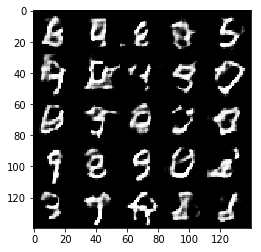

Epoch: 1 Gen Loss: 1.1128 Disc Loss: 1.1549
Epoch: 1 Gen Loss: 1.0164 Disc Loss: 1.2633
Epoch: 1 Gen Loss: 0.7690 Disc Loss: 1.5548
Epoch: 1 Gen Loss: 0.9256 Disc Loss: 1.3077
Epoch: 1 Gen Loss: 1.2837 Disc Loss: 0.9473
Epoch: 1 Gen Loss: 1.0823 Disc Loss: 1.1996
Epoch: 1 Gen Loss: 1.0198 Disc Loss: 1.3564
Epoch: 1 Gen Loss: 1.0884 Disc Loss: 1.2496
Epoch: 1 Gen Loss: 0.7949 Disc Loss: 1.4212
Epoch: 1 Gen Loss: 0.8757 Disc Loss: 1.3237


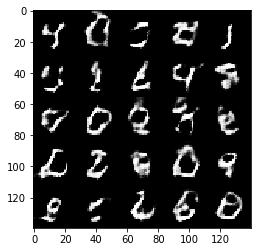

Epoch: 1 Gen Loss: 1.0773 Disc Loss: 1.1347
Epoch: 1 Gen Loss: 0.7999 Disc Loss: 1.4750
Epoch: 1 Gen Loss: 0.8987 Disc Loss: 1.3028
Epoch: 1 Gen Loss: 1.1044 Disc Loss: 1.0391
Epoch: 1 Gen Loss: 1.0814 Disc Loss: 1.1944
Epoch: 1 Gen Loss: 0.9103 Disc Loss: 1.3275
Epoch: 1 Gen Loss: 0.8319 Disc Loss: 1.4111
Epoch: 1 Gen Loss: 0.8451 Disc Loss: 1.3993
Epoch: 1 Gen Loss: 1.0583 Disc Loss: 1.0599
Epoch: 1 Gen Loss: 0.8811 Disc Loss: 1.3103


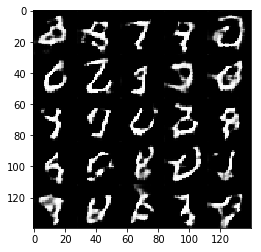

Epoch: 1 Gen Loss: 1.0323 Disc Loss: 1.1616
Epoch: 1 Gen Loss: 1.0396 Disc Loss: 1.2515
Epoch: 1 Gen Loss: 0.8586 Disc Loss: 1.3381
Epoch: 1 Gen Loss: 1.0849 Disc Loss: 1.1922
Epoch: 1 Gen Loss: 0.7938 Disc Loss: 1.3685
Epoch: 1 Gen Loss: 0.9284 Disc Loss: 1.2447
Epoch: 1 Gen Loss: 1.0150 Disc Loss: 1.2129
Epoch: 1 Gen Loss: 0.9554 Disc Loss: 1.2496
Epoch: 1 Gen Loss: 0.9982 Disc Loss: 1.2105
Epoch: 1 Gen Loss: 0.9063 Disc Loss: 1.3426


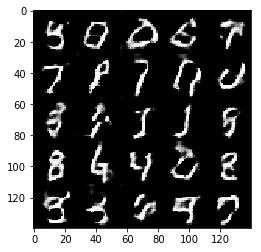

Epoch: 1 Gen Loss: 1.0845 Disc Loss: 1.2164
Epoch: 1 Gen Loss: 1.0929 Disc Loss: 1.2828
Epoch: 1 Gen Loss: 0.8340 Disc Loss: 1.2897
Epoch: 1 Gen Loss: 0.8664 Disc Loss: 1.2583
Epoch: 1 Gen Loss: 0.6067 Disc Loss: 1.6304
Epoch: 1 Gen Loss: 0.9641 Disc Loss: 1.2041
Epoch: 1 Gen Loss: 1.1309 Disc Loss: 1.1998


In [13]:
batch_size = 64
z_dim = 128
learning_rate = 0.0001
beta1 = 0.8


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2
losses = {}
mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    losses = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### Plots
View of how the generator and discriminator losses change with the batches

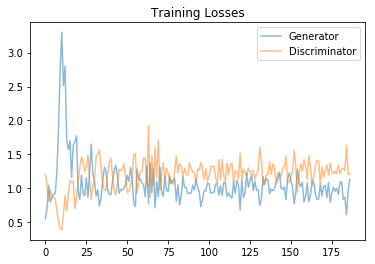

In [14]:
pyplot.plot(losses['g_loss'], label='Generator', alpha=0.5)
pyplot.plot(losses['d_loss'], label='Discriminator', alpha=0.5)
pyplot.title('Training Losses')
pyplot.legend()
pyplot.show()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch: 0 Gen Loss: 0.5718 Disc Loss: 1.1810
Epoch: 0 Gen Loss: 0.8137 Disc Loss: 0.9711
Epoch: 0 Gen Loss: 0.8305 Disc Loss: 0.9880
Epoch: 0 Gen Loss: 0.8400 Disc Loss: 0.9570
Epoch: 0 Gen Loss: 0.7303 Disc Loss: 1.0060
Epoch: 0 Gen Loss: 0.8460 Disc Loss: 0.8992
Epoch: 0 Gen Loss: 0.9123 Disc Loss: 0.8539
Epoch: 0 Gen Loss: 1.4594 Disc Loss: 0.6210
Epoch: 0 Gen Loss: 1.7671 Disc Loss: 0.5385
Epoch: 0 Gen Loss: 1.0590 Disc Loss: 0.8298


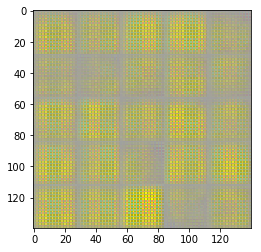

Epoch: 0 Gen Loss: 2.3898 Disc Loss: 0.6871
Epoch: 0 Gen Loss: 3.1085 Disc Loss: 0.5469
Epoch: 0 Gen Loss: 1.8128 Disc Loss: 0.8461
Epoch: 0 Gen Loss: 2.0525 Disc Loss: 0.9982
Epoch: 0 Gen Loss: 1.9211 Disc Loss: 0.7070
Epoch: 0 Gen Loss: 1.7371 Disc Loss: 0.8349
Epoch: 0 Gen Loss: 1.3413 Disc Loss: 1.0409
Epoch: 0 Gen Loss: 1.6900 Disc Loss: 0.7661
Epoch: 0 Gen Loss: 1.1727 Disc Loss: 1.0515
Epoch: 0 Gen Loss: 1.6089 Disc Loss: 0.7732


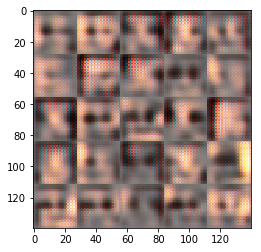

Epoch: 0 Gen Loss: 0.8462 Disc Loss: 1.3672
Epoch: 0 Gen Loss: 1.5971 Disc Loss: 0.7826
Epoch: 0 Gen Loss: 1.5289 Disc Loss: 0.8949
Epoch: 0 Gen Loss: 1.5247 Disc Loss: 1.2527
Epoch: 0 Gen Loss: 0.9760 Disc Loss: 1.2832
Epoch: 0 Gen Loss: 2.4591 Disc Loss: 0.6554
Epoch: 0 Gen Loss: 1.5108 Disc Loss: 1.1268
Epoch: 0 Gen Loss: 1.5808 Disc Loss: 1.1244
Epoch: 0 Gen Loss: 1.6603 Disc Loss: 0.7782
Epoch: 0 Gen Loss: 1.5841 Disc Loss: 0.8015


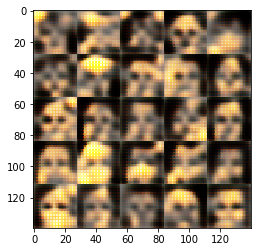

Epoch: 0 Gen Loss: 1.2254 Disc Loss: 0.9518
Epoch: 0 Gen Loss: 0.8182 Disc Loss: 1.2442
Epoch: 0 Gen Loss: 1.2719 Disc Loss: 0.8157
Epoch: 0 Gen Loss: 1.6337 Disc Loss: 0.7356
Epoch: 0 Gen Loss: 1.3785 Disc Loss: 1.0804
Epoch: 0 Gen Loss: 1.6487 Disc Loss: 0.8568
Epoch: 0 Gen Loss: 1.2997 Disc Loss: 1.1374
Epoch: 0 Gen Loss: 1.5694 Disc Loss: 1.0281
Epoch: 0 Gen Loss: 2.0672 Disc Loss: 0.8027
Epoch: 0 Gen Loss: 1.1548 Disc Loss: 1.5907


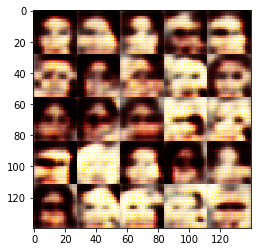

Epoch: 0 Gen Loss: 1.4981 Disc Loss: 1.0195
Epoch: 0 Gen Loss: 1.8686 Disc Loss: 0.9177
Epoch: 0 Gen Loss: 1.6587 Disc Loss: 0.9121
Epoch: 0 Gen Loss: 1.1910 Disc Loss: 1.2133
Epoch: 0 Gen Loss: 1.4103 Disc Loss: 1.0527
Epoch: 0 Gen Loss: 1.5501 Disc Loss: 0.9306
Epoch: 0 Gen Loss: 1.0815 Disc Loss: 1.2225
Epoch: 0 Gen Loss: 1.1462 Disc Loss: 1.1394
Epoch: 0 Gen Loss: 1.1405 Disc Loss: 1.0809
Epoch: 0 Gen Loss: 0.7907 Disc Loss: 1.4998


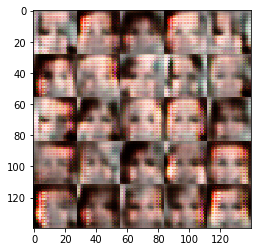

Epoch: 0 Gen Loss: 1.0302 Disc Loss: 1.2450
Epoch: 0 Gen Loss: 1.2740 Disc Loss: 0.9900
Epoch: 0 Gen Loss: 1.1205 Disc Loss: 1.2638
Epoch: 0 Gen Loss: 0.9347 Disc Loss: 1.4735
Epoch: 0 Gen Loss: 1.1582 Disc Loss: 1.0956
Epoch: 0 Gen Loss: 1.1290 Disc Loss: 1.1970
Epoch: 0 Gen Loss: 0.9165 Disc Loss: 1.4917
Epoch: 0 Gen Loss: 1.1050 Disc Loss: 1.0501
Epoch: 0 Gen Loss: 1.1978 Disc Loss: 0.9909
Epoch: 0 Gen Loss: 1.1126 Disc Loss: 1.1344


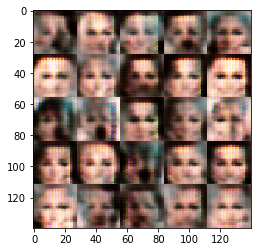

Epoch: 0 Gen Loss: 1.0334 Disc Loss: 1.0847
Epoch: 0 Gen Loss: 1.2531 Disc Loss: 1.0393
Epoch: 0 Gen Loss: 0.9116 Disc Loss: 1.4388
Epoch: 0 Gen Loss: 0.9118 Disc Loss: 1.4036
Epoch: 0 Gen Loss: 0.9700 Disc Loss: 1.1963
Epoch: 0 Gen Loss: 1.1308 Disc Loss: 1.0368
Epoch: 0 Gen Loss: 1.2113 Disc Loss: 1.0384
Epoch: 0 Gen Loss: 1.0486 Disc Loss: 1.1278
Epoch: 0 Gen Loss: 0.9813 Disc Loss: 1.4100
Epoch: 0 Gen Loss: 0.8447 Disc Loss: 1.4344


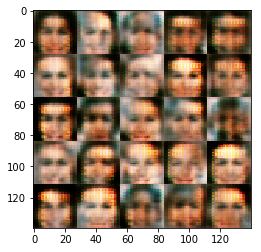

Epoch: 0 Gen Loss: 0.9851 Disc Loss: 1.2647
Epoch: 0 Gen Loss: 1.2040 Disc Loss: 1.2126
Epoch: 0 Gen Loss: 1.3639 Disc Loss: 1.0377
Epoch: 0 Gen Loss: 1.2916 Disc Loss: 1.0948
Epoch: 0 Gen Loss: 1.0777 Disc Loss: 1.2005
Epoch: 0 Gen Loss: 1.1097 Disc Loss: 1.0635
Epoch: 0 Gen Loss: 0.9770 Disc Loss: 1.1444
Epoch: 0 Gen Loss: 0.9096 Disc Loss: 1.2962
Epoch: 0 Gen Loss: 0.7272 Disc Loss: 1.4075
Epoch: 0 Gen Loss: 0.9469 Disc Loss: 1.2239


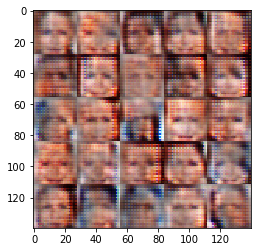

Epoch: 0 Gen Loss: 1.2411 Disc Loss: 1.2910
Epoch: 0 Gen Loss: 1.8282 Disc Loss: 0.7561
Epoch: 0 Gen Loss: 0.4352 Disc Loss: 2.8068
Epoch: 0 Gen Loss: 1.1876 Disc Loss: 1.1597
Epoch: 0 Gen Loss: 1.4460 Disc Loss: 0.8582
Epoch: 0 Gen Loss: 1.3208 Disc Loss: 0.8946
Epoch: 0 Gen Loss: 1.0253 Disc Loss: 1.2584
Epoch: 0 Gen Loss: 0.9104 Disc Loss: 1.3636
Epoch: 0 Gen Loss: 0.9853 Disc Loss: 1.1711
Epoch: 0 Gen Loss: 0.9655 Disc Loss: 1.1492


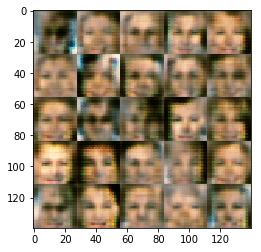

Epoch: 0 Gen Loss: 0.9770 Disc Loss: 1.1694
Epoch: 0 Gen Loss: 0.6163 Disc Loss: 1.6795
Epoch: 0 Gen Loss: 0.9472 Disc Loss: 1.1842
Epoch: 0 Gen Loss: 1.3236 Disc Loss: 0.9268
Epoch: 0 Gen Loss: 1.1398 Disc Loss: 1.0523
Epoch: 0 Gen Loss: 0.7808 Disc Loss: 1.6820
Epoch: 0 Gen Loss: 0.9786 Disc Loss: 1.2169
Epoch: 0 Gen Loss: 1.2456 Disc Loss: 1.0838
Epoch: 0 Gen Loss: 0.8276 Disc Loss: 1.6108
Epoch: 0 Gen Loss: 0.7972 Disc Loss: 1.4665


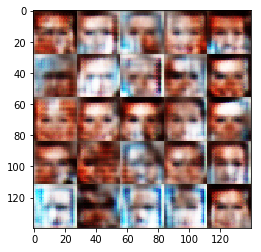

Epoch: 0 Gen Loss: 1.1965 Disc Loss: 1.0240
Epoch: 0 Gen Loss: 1.1193 Disc Loss: 1.0936
Epoch: 0 Gen Loss: 0.8715 Disc Loss: 1.4980
Epoch: 0 Gen Loss: 0.8803 Disc Loss: 1.4294
Epoch: 0 Gen Loss: 0.9698 Disc Loss: 1.1971
Epoch: 0 Gen Loss: 0.9400 Disc Loss: 1.2264
Epoch: 0 Gen Loss: 0.9502 Disc Loss: 1.1294
Epoch: 0 Gen Loss: 0.9553 Disc Loss: 1.1795
Epoch: 0 Gen Loss: 0.6511 Disc Loss: 1.6072
Epoch: 0 Gen Loss: 0.7308 Disc Loss: 1.3674


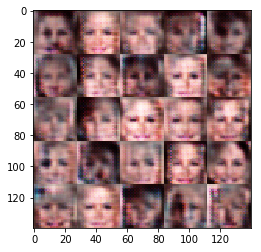

Epoch: 0 Gen Loss: 0.9636 Disc Loss: 1.1471
Epoch: 0 Gen Loss: 0.9980 Disc Loss: 1.0852
Epoch: 0 Gen Loss: 0.8520 Disc Loss: 1.3543
Epoch: 0 Gen Loss: 1.0846 Disc Loss: 1.2805
Epoch: 0 Gen Loss: 1.1454 Disc Loss: 1.1787
Epoch: 0 Gen Loss: 1.1041 Disc Loss: 1.3357
Epoch: 0 Gen Loss: 0.7478 Disc Loss: 1.7007
Epoch: 0 Gen Loss: 0.8580 Disc Loss: 1.3344
Epoch: 0 Gen Loss: 1.0635 Disc Loss: 1.0545
Epoch: 0 Gen Loss: 1.1275 Disc Loss: 1.0686


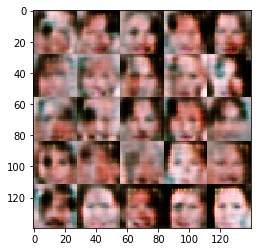

Epoch: 0 Gen Loss: 0.9388 Disc Loss: 1.1392
Epoch: 0 Gen Loss: 0.9317 Disc Loss: 1.2411
Epoch: 0 Gen Loss: 0.8818 Disc Loss: 1.3436
Epoch: 0 Gen Loss: 0.9076 Disc Loss: 1.4095
Epoch: 0 Gen Loss: 0.9964 Disc Loss: 1.3031
Epoch: 0 Gen Loss: 1.1179 Disc Loss: 1.2021
Epoch: 0 Gen Loss: 1.0060 Disc Loss: 1.2649
Epoch: 0 Gen Loss: 0.9680 Disc Loss: 1.2412
Epoch: 0 Gen Loss: 0.9427 Disc Loss: 1.2788
Epoch: 0 Gen Loss: 0.7764 Disc Loss: 1.5179


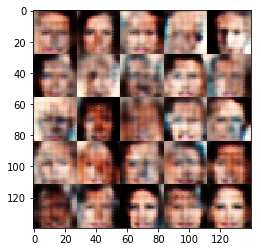

Epoch: 0 Gen Loss: 0.7270 Disc Loss: 1.4441
Epoch: 0 Gen Loss: 0.9582 Disc Loss: 1.1383
Epoch: 0 Gen Loss: 1.0492 Disc Loss: 1.0349
Epoch: 0 Gen Loss: 0.8966 Disc Loss: 1.2996
Epoch: 0 Gen Loss: 0.8943 Disc Loss: 1.3034
Epoch: 0 Gen Loss: 0.8585 Disc Loss: 1.3307
Epoch: 0 Gen Loss: 0.8846 Disc Loss: 1.3577
Epoch: 0 Gen Loss: 1.1163 Disc Loss: 1.2171
Epoch: 0 Gen Loss: 0.9406 Disc Loss: 1.2743
Epoch: 0 Gen Loss: 0.8221 Disc Loss: 1.5315


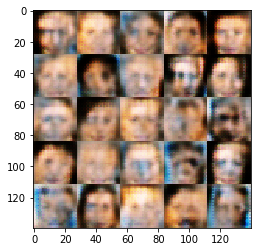

Epoch: 0 Gen Loss: 0.9841 Disc Loss: 1.2095
Epoch: 0 Gen Loss: 1.0625 Disc Loss: 1.1649
Epoch: 0 Gen Loss: 0.9890 Disc Loss: 1.2457
Epoch: 0 Gen Loss: 0.9236 Disc Loss: 1.2219
Epoch: 0 Gen Loss: 1.0300 Disc Loss: 1.2455
Epoch: 0 Gen Loss: 0.8462 Disc Loss: 1.5081
Epoch: 0 Gen Loss: 0.9118 Disc Loss: 1.3949
Epoch: 0 Gen Loss: 1.0858 Disc Loss: 1.1800
Epoch: 0 Gen Loss: 1.1172 Disc Loss: 1.0767
Epoch: 0 Gen Loss: 1.0757 Disc Loss: 1.2583


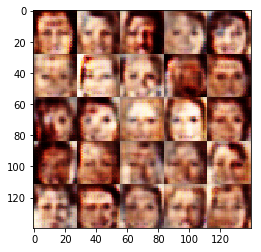

Epoch: 0 Gen Loss: 0.7891 Disc Loss: 1.5187
Epoch: 0 Gen Loss: 0.9455 Disc Loss: 1.2680
Epoch: 0 Gen Loss: 0.9806 Disc Loss: 1.1725
Epoch: 0 Gen Loss: 1.1030 Disc Loss: 1.1257
Epoch: 0 Gen Loss: 1.1051 Disc Loss: 1.0909
Epoch: 0 Gen Loss: 0.8385 Disc Loss: 1.4473
Epoch: 0 Gen Loss: 1.1223 Disc Loss: 1.1440
Epoch: 0 Gen Loss: 1.0717 Disc Loss: 1.1798
Epoch: 0 Gen Loss: 0.8677 Disc Loss: 1.5070
Epoch: 0 Gen Loss: 0.9347 Disc Loss: 1.3353


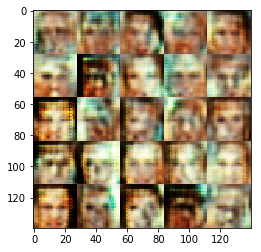

Epoch: 0 Gen Loss: 1.1712 Disc Loss: 1.1715
Epoch: 0 Gen Loss: 1.0432 Disc Loss: 1.1985
Epoch: 0 Gen Loss: 1.0115 Disc Loss: 1.4507
Epoch: 0 Gen Loss: 1.0300 Disc Loss: 1.1671
Epoch: 0 Gen Loss: 1.0011 Disc Loss: 1.2254
Epoch: 0 Gen Loss: 1.0149 Disc Loss: 1.2349
Epoch: 0 Gen Loss: 0.9366 Disc Loss: 1.2946
Epoch: 0 Gen Loss: 0.9506 Disc Loss: 1.2435
Epoch: 0 Gen Loss: 1.0356 Disc Loss: 1.2081
Epoch: 0 Gen Loss: 0.9138 Disc Loss: 1.2782


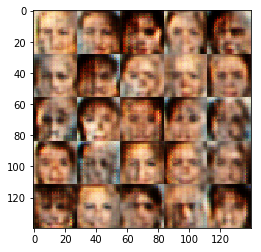

Epoch: 0 Gen Loss: 0.8630 Disc Loss: 1.3240
Epoch: 0 Gen Loss: 0.9076 Disc Loss: 1.2742
Epoch: 0 Gen Loss: 1.0036 Disc Loss: 1.1453
Epoch: 0 Gen Loss: 1.0040 Disc Loss: 1.1198
Epoch: 0 Gen Loss: 0.9287 Disc Loss: 1.5159
Epoch: 0 Gen Loss: 0.7499 Disc Loss: 1.4853
Epoch: 0 Gen Loss: 0.9056 Disc Loss: 1.2637
Epoch: 0 Gen Loss: 0.8856 Disc Loss: 1.1916
Epoch: 0 Gen Loss: 0.9686 Disc Loss: 1.1883
Epoch: 0 Gen Loss: 0.8101 Disc Loss: 1.4145


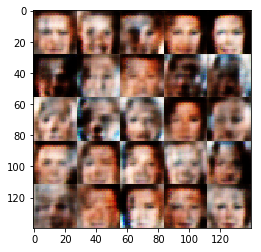

Epoch: 0 Gen Loss: 0.8534 Disc Loss: 1.4172
Epoch: 0 Gen Loss: 0.9611 Disc Loss: 1.3042
Epoch: 0 Gen Loss: 0.9467 Disc Loss: 1.2473
Epoch: 0 Gen Loss: 0.9712 Disc Loss: 1.3353
Epoch: 0 Gen Loss: 0.9548 Disc Loss: 1.2925
Epoch: 0 Gen Loss: 0.8855 Disc Loss: 1.3502
Epoch: 0 Gen Loss: 0.8852 Disc Loss: 1.3013
Epoch: 0 Gen Loss: 0.8775 Disc Loss: 1.2735
Epoch: 0 Gen Loss: 0.9477 Disc Loss: 1.2290
Epoch: 0 Gen Loss: 0.8349 Disc Loss: 1.3356


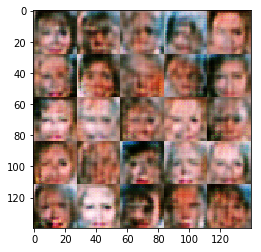

Epoch: 0 Gen Loss: 0.8464 Disc Loss: 1.3427
Epoch: 0 Gen Loss: 0.9127 Disc Loss: 1.2634
Epoch: 0 Gen Loss: 0.9433 Disc Loss: 1.2591
Epoch: 0 Gen Loss: 0.9179 Disc Loss: 1.2822
Epoch: 0 Gen Loss: 0.9528 Disc Loss: 1.1889
Epoch: 0 Gen Loss: 1.1825 Disc Loss: 1.1015
Epoch: 0 Gen Loss: 0.8009 Disc Loss: 1.3673
Epoch: 0 Gen Loss: 0.8728 Disc Loss: 1.3041
Epoch: 0 Gen Loss: 0.9074 Disc Loss: 1.2447
Epoch: 0 Gen Loss: 0.9330 Disc Loss: 1.3058


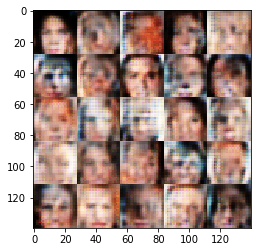

Epoch: 0 Gen Loss: 0.8245 Disc Loss: 1.4652
Epoch: 0 Gen Loss: 0.9764 Disc Loss: 1.1317
Epoch: 0 Gen Loss: 1.0731 Disc Loss: 1.1308
Epoch: 0 Gen Loss: 1.0931 Disc Loss: 1.1186
Epoch: 0 Gen Loss: 0.7847 Disc Loss: 1.6780
Epoch: 0 Gen Loss: 0.8596 Disc Loss: 1.3641
Epoch: 0 Gen Loss: 1.0296 Disc Loss: 1.1487
Epoch: 0 Gen Loss: 1.0191 Disc Loss: 1.1578
Epoch: 0 Gen Loss: 0.8504 Disc Loss: 1.3014
Epoch: 0 Gen Loss: 0.8983 Disc Loss: 1.3696


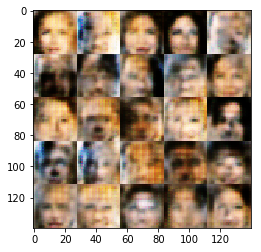

Epoch: 0 Gen Loss: 0.8842 Disc Loss: 1.2600
Epoch: 0 Gen Loss: 0.8751 Disc Loss: 1.2159
Epoch: 0 Gen Loss: 0.9201 Disc Loss: 1.2995
Epoch: 0 Gen Loss: 0.8523 Disc Loss: 1.5057
Epoch: 0 Gen Loss: 0.8537 Disc Loss: 1.3681
Epoch: 0 Gen Loss: 0.9953 Disc Loss: 1.2067
Epoch: 0 Gen Loss: 0.8952 Disc Loss: 1.3116
Epoch: 0 Gen Loss: 0.7375 Disc Loss: 1.4983
Epoch: 0 Gen Loss: 0.8732 Disc Loss: 1.4010
Epoch: 0 Gen Loss: 0.9742 Disc Loss: 1.2079


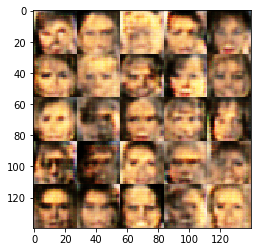

Epoch: 0 Gen Loss: 0.9168 Disc Loss: 1.2665
Epoch: 0 Gen Loss: 0.7889 Disc Loss: 1.4267
Epoch: 0 Gen Loss: 0.8362 Disc Loss: 1.3360
Epoch: 0 Gen Loss: 0.9105 Disc Loss: 1.1705
Epoch: 0 Gen Loss: 1.0158 Disc Loss: 1.0810
Epoch: 0 Gen Loss: 0.8282 Disc Loss: 1.2354
Epoch: 0 Gen Loss: 0.7887 Disc Loss: 1.4135
Epoch: 0 Gen Loss: 0.8456 Disc Loss: 1.3317
Epoch: 0 Gen Loss: 1.0038 Disc Loss: 1.1897
Epoch: 0 Gen Loss: 0.8588 Disc Loss: 1.3185


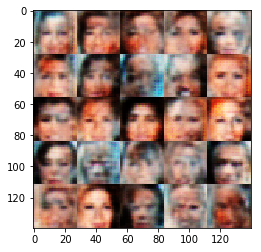

Epoch: 0 Gen Loss: 0.7825 Disc Loss: 1.4000
Epoch: 0 Gen Loss: 0.9873 Disc Loss: 1.2454
Epoch: 0 Gen Loss: 0.8575 Disc Loss: 1.3612
Epoch: 0 Gen Loss: 0.8627 Disc Loss: 1.2775
Epoch: 0 Gen Loss: 1.0021 Disc Loss: 1.1743
Epoch: 0 Gen Loss: 0.8745 Disc Loss: 1.3237
Epoch: 0 Gen Loss: 0.6479 Disc Loss: 1.7581
Epoch: 0 Gen Loss: 0.8864 Disc Loss: 1.3425
Epoch: 0 Gen Loss: 1.0438 Disc Loss: 1.1295
Epoch: 0 Gen Loss: 1.0506 Disc Loss: 1.1494


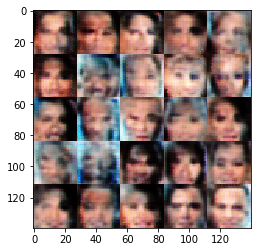

Epoch: 0 Gen Loss: 0.8245 Disc Loss: 1.4253
Epoch: 0 Gen Loss: 0.7573 Disc Loss: 1.5248
Epoch: 0 Gen Loss: 0.9285 Disc Loss: 1.2184
Epoch: 0 Gen Loss: 1.0114 Disc Loss: 1.1932
Epoch: 0 Gen Loss: 0.9591 Disc Loss: 1.2779
Epoch: 0 Gen Loss: 0.8778 Disc Loss: 1.3499
Epoch: 0 Gen Loss: 0.8728 Disc Loss: 1.2435
Epoch: 0 Gen Loss: 0.9138 Disc Loss: 1.2527
Epoch: 0 Gen Loss: 0.9218 Disc Loss: 1.2974
Epoch: 0 Gen Loss: 0.9022 Disc Loss: 1.3780


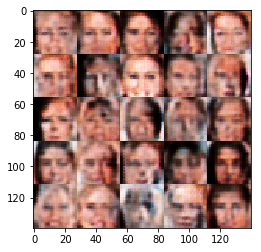

Epoch: 0 Gen Loss: 0.8870 Disc Loss: 1.3319
Epoch: 0 Gen Loss: 0.8357 Disc Loss: 1.3843
Epoch: 0 Gen Loss: 0.8955 Disc Loss: 1.3126
Epoch: 0 Gen Loss: 0.9057 Disc Loss: 1.2402
Epoch: 0 Gen Loss: 0.9147 Disc Loss: 1.2478
Epoch: 0 Gen Loss: 0.8652 Disc Loss: 1.3712
Epoch: 0 Gen Loss: 0.8210 Disc Loss: 1.3952
Epoch: 0 Gen Loss: 0.8404 Disc Loss: 1.3205
Epoch: 0 Gen Loss: 0.8592 Disc Loss: 1.3245
Epoch: 0 Gen Loss: 0.8433 Disc Loss: 1.3558


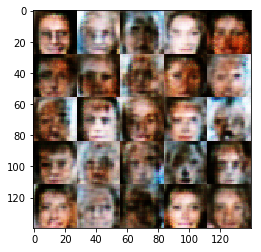

Epoch: 0 Gen Loss: 0.8511 Disc Loss: 1.3546
Epoch: 0 Gen Loss: 0.8618 Disc Loss: 1.3077
Epoch: 0 Gen Loss: 0.9592 Disc Loss: 1.1978
Epoch: 0 Gen Loss: 0.8831 Disc Loss: 1.3647
Epoch: 0 Gen Loss: 0.8276 Disc Loss: 1.4572
Epoch: 0 Gen Loss: 0.7656 Disc Loss: 1.4916
Epoch: 0 Gen Loss: 0.9339 Disc Loss: 1.2712
Epoch: 0 Gen Loss: 0.8980 Disc Loss: 1.2057
Epoch: 0 Gen Loss: 0.9207 Disc Loss: 1.2376
Epoch: 0 Gen Loss: 0.8481 Disc Loss: 1.3721


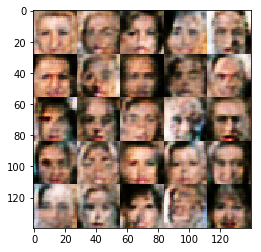

Epoch: 0 Gen Loss: 0.8499 Disc Loss: 1.4371
Epoch: 0 Gen Loss: 0.8310 Disc Loss: 1.4147
Epoch: 0 Gen Loss: 0.9128 Disc Loss: 1.2920
Epoch: 0 Gen Loss: 0.9457 Disc Loss: 1.2340
Epoch: 0 Gen Loss: 0.7384 Disc Loss: 1.4622
Epoch: 0 Gen Loss: 0.8091 Disc Loss: 1.3444
Epoch: 0 Gen Loss: 0.8278 Disc Loss: 1.3468
Epoch: 0 Gen Loss: 0.8587 Disc Loss: 1.3210
Epoch: 0 Gen Loss: 0.8801 Disc Loss: 1.2519
Epoch: 0 Gen Loss: 0.8080 Disc Loss: 1.3246


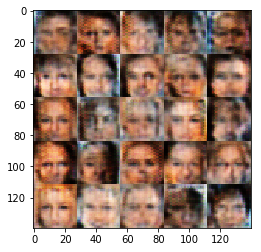

Epoch: 0 Gen Loss: 0.7898 Disc Loss: 1.4124
Epoch: 0 Gen Loss: 0.8272 Disc Loss: 1.3776
Epoch: 0 Gen Loss: 0.8917 Disc Loss: 1.2665
Epoch: 0 Gen Loss: 0.9215 Disc Loss: 1.2109
Epoch: 0 Gen Loss: 0.8175 Disc Loss: 1.2787
Epoch: 0 Gen Loss: 0.7266 Disc Loss: 1.4842
Epoch: 0 Gen Loss: 0.8818 Disc Loss: 1.3258
Epoch: 0 Gen Loss: 0.8420 Disc Loss: 1.4175
Epoch: 0 Gen Loss: 0.9159 Disc Loss: 1.3549
Epoch: 0 Gen Loss: 0.9973 Disc Loss: 1.2100


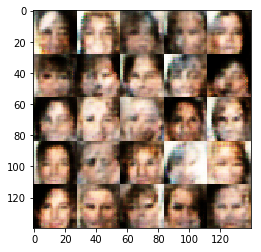

Epoch: 0 Gen Loss: 0.9334 Disc Loss: 1.3126
Epoch: 0 Gen Loss: 0.8881 Disc Loss: 1.3748
Epoch: 0 Gen Loss: 0.9334 Disc Loss: 1.2738
Epoch: 0 Gen Loss: 1.0235 Disc Loss: 1.2342
Epoch: 0 Gen Loss: 0.8530 Disc Loss: 1.3329
Epoch: 0 Gen Loss: 0.9779 Disc Loss: 1.1440
Epoch: 0 Gen Loss: 0.8048 Disc Loss: 1.5356
Epoch: 0 Gen Loss: 0.6788 Disc Loss: 1.4656
Epoch: 0 Gen Loss: 0.8529 Disc Loss: 1.2377
Epoch: 0 Gen Loss: 1.0801 Disc Loss: 1.0283


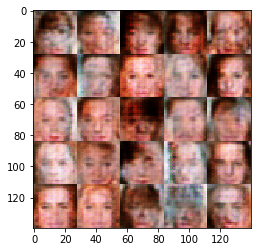

Epoch: 0 Gen Loss: 1.0581 Disc Loss: 1.1617
Epoch: 0 Gen Loss: 0.7315 Disc Loss: 1.5492
Epoch: 0 Gen Loss: 0.6570 Disc Loss: 1.8748
Epoch: 0 Gen Loss: 0.9831 Disc Loss: 1.2860
Epoch: 0 Gen Loss: 1.0570 Disc Loss: 1.1421
Epoch: 0 Gen Loss: 0.9352 Disc Loss: 1.2748
Epoch: 0 Gen Loss: 0.9551 Disc Loss: 1.2273
Epoch: 0 Gen Loss: 0.9437 Disc Loss: 1.1582
Epoch: 0 Gen Loss: 1.0035 Disc Loss: 1.3567
Epoch: 0 Gen Loss: 0.8203 Disc Loss: 1.6065


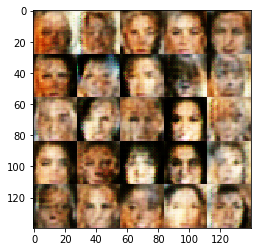

Epoch: 0 Gen Loss: 1.0180 Disc Loss: 1.1963
Epoch: 0 Gen Loss: 1.0359 Disc Loss: 1.1441
Epoch: 0 Gen Loss: 0.8150 Disc Loss: 1.4842
Epoch: 0 Gen Loss: 0.7970 Disc Loss: 1.4077
Epoch: 0 Gen Loss: 0.9100 Disc Loss: 1.1878
Epoch: 0 Gen Loss: 0.8682 Disc Loss: 1.3397


In [15]:
batch_size = 64
z_dim = 128
learning_rate = 0.0001
beta1 = 0.8


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.